# CHAPTER 9 - Quantum Support Vector Machines - Code

In [110]:
!pip install scikit-learn
!pip install qiskit_machine_learning

In [111]:
import numpy as np
import pennylane as qml
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [126]:
x,y = load_wine(return_X_y=True)
x = x[:59+71]
y = y[:59+71]

In [128]:
x_tr, x_test, y_tr, y_test = train_test_split(x, y, test_size=0.2)
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)
x_test = scaler.transform(x_test)
x_test = np.clip(x_test,0,1)

In [129]:
x_test

array([[0.87997303, 1.        , 0.65944272, 0.71666667, 0.56953642,
        0.67525773, 0.52165354, 0.45454545, 0.56145251, 0.29213483,
        0.42690058, 0.775     , 0.22619048],
       [0.95886716, 0.38374718, 0.7120743 , 0.54333333, 0.78145695,
        0.82474227, 0.59055118, 0.39393939, 0.56703911, 0.71685393,
        0.5497076 , 0.8275    , 0.57738095],
       [0.87188132, 0.85778781, 0.82043344, 0.62      , 0.67549669,
        0.62113402, 0.47440945, 0.37878788, 0.55307263, 0.50561798,
        0.60233918, 0.88      , 0.45833333],
       [0.84086312, 0.34311512, 0.68111455, 0.63333333, 1.        ,
        0.6443299 , 0.44685039, 0.48484848, 0.91620112, 0.29213483,
        0.67836257, 0.6575    , 0.5577381 ],
       [0.90424815, 0.86681716, 0.65634675, 0.62666667, 0.59602649,
        0.6314433 , 0.52755906, 0.40909091, 0.41340782, 0.48089888,
        0.53216374, 0.75      , 0.61607143],
       [0.85637222, 0.87358916, 0.74303406, 0.76666667, 0.66887417,
        0.72938144, 0.50196

C:\Users\adria\AppData\Local\Temp\ipykernel_5100\2496680132.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


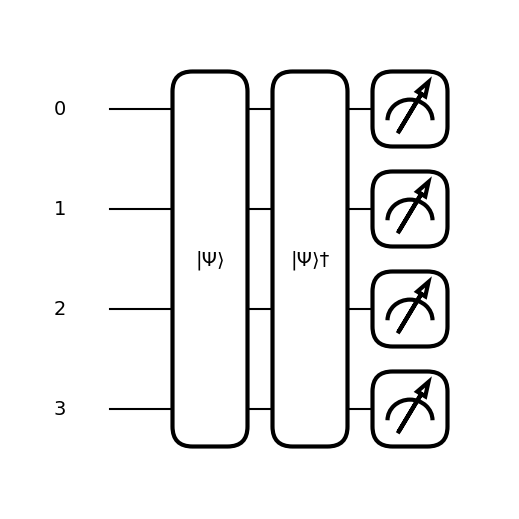

In [130]:
nqubits = 4
dev = qml.device("lightning.qubit", wires=nqubits)

@qml.qnode(dev)
def amp_encode_quantum_circuit(a, b):
    qml.AmplitudeEmbedding(a, wires=range(nqubits), pad_with=0, normalize=True)
    qml.adjoint(qml.AmplitudeEmbedding)(b, wires=range(nqubits), pad_with=0, normalize=True)
    return qml.probs(wires=range(nqubits))

qcirc = qml.QNode(amp_encode_quantum_circuit, dev)
fig, ax = qml.draw_mpl(qcirc)(a=x_tr[0], b=x_tr[0])
fig.show()

In [131]:
from sklearn.svm import SVC
def qkernel(A,B):
    return np.array([[amp_encode_quantum_circuit(a, b)[0] for b in B] for a in A])

svm = SVC(kernel=qkernel).fit(x_tr,y_tr)

In [132]:
from sklearn.metrics import accuracy_score

print("The accuracy of the quantum SVM with amplitude encoding is: ", accuracy_score(svm.predict(x_test), y_test)*100, "%")

The accuracy of the quantum SVM with amplitude encoding is:  92.3076923076923 %


In [133]:
import time
start = time.time()
svm.predict(x_test[0:1])
end = time.time()
print("The time taken by the quantum SVM is:", end-start, "seconds for a single prediction.")

The time taken by the quantum SVM is: 0.538339376449585 seconds for a single prediction.


In [135]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)

xred_tr = pca.fit_transform(x_tr)
xred_test = pca.transform(x_test)

C:\Users\adria\AppData\Local\Temp\ipykernel_5100\2222580752.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


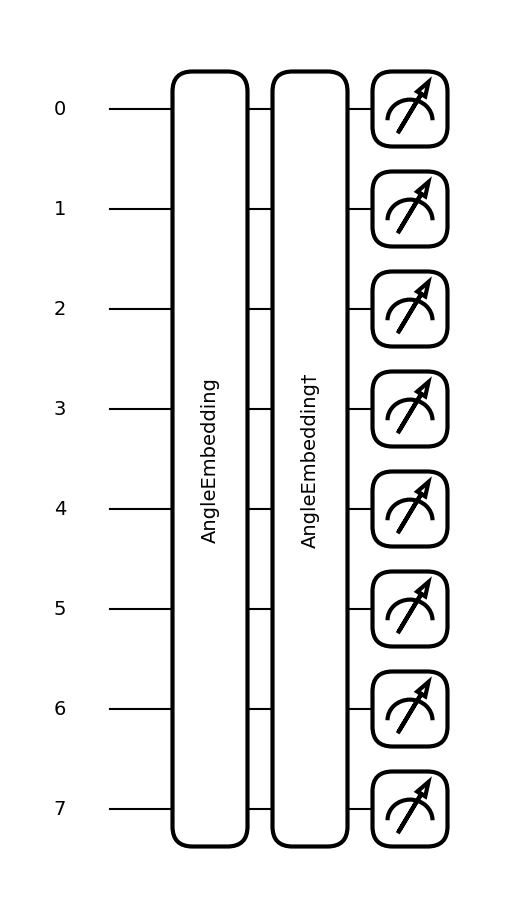

In [137]:
nqubits = 8
dev2 = qml.device("lightning.qubit", wires=nqubits)

@qml.qnode(dev2)
def angle_encode_quantum_circuit(a, b):
    qml.AngleEmbedding(a, wires=range(nqubits))
    qml.adjoint(qml.AngleEmbedding(b, wires=range(nqubits)))
    return qml.probs(wires=range(nqubits))

qcirc = qml.QNode(angle_encode_quantum_circuit, dev2)
fig, ax = qml.draw_mpl(qcirc)(a=xred_tr[0], b=xred_tr[0])
fig.show()

In [139]:
def qkernel(A,B):
    return np.array([[angle_encode_quantum_circuit(a, b)[0] for b in B] for a in A])

svm_red = SVC(kernel=qkernel).fit(xred_tr,y_tr)

In [122]:
print("The accuracy of quantum SVM with angle encoding is:", accuracy_score(svm_red.predict(xred_test), y_test)*100, "%")

The accuracy of quantum SVM with angle encoding is: 84.61538461538461 %


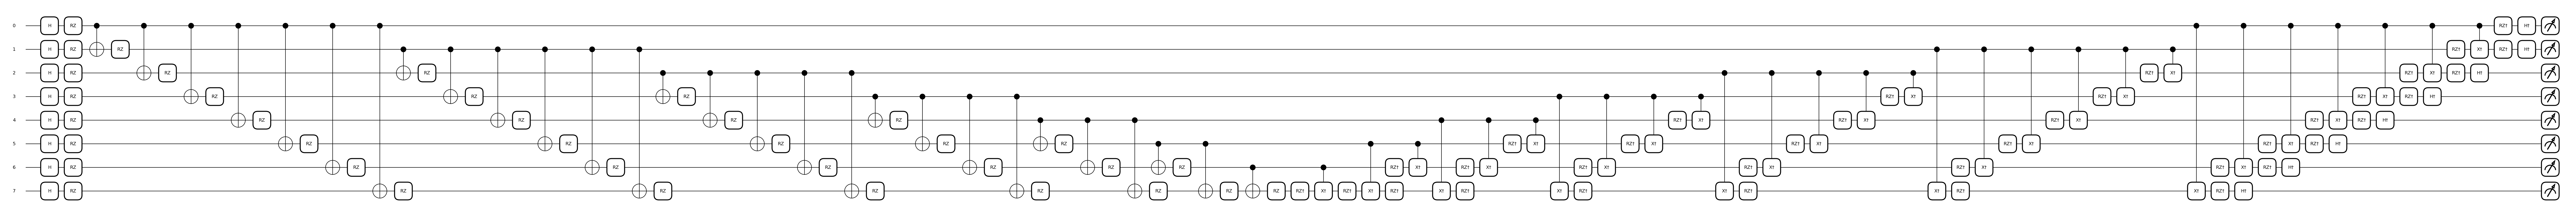

In [150]:
from itertools import combinations

nqubits = 8
dev3 = qml.device("lightning.qubit", wires=nqubits)

def ZZFeatureMap(nqubits, data):
    for i in range(nqubits):
        qml.Hadamard(wires=i)
        qml.RZ(2*data[i], wires=i)

    for pair in combinations(range(nqubits), 2):
        qml.CNOT(wires=pair)
        qml.RZ(2*(np.pi-data[pair[0]])*(np.pi-data[pair[1]]),wires=pair[1])

@qml.qnode(dev3)
def ZZFeatureMapQC(a,b):
    ZZFeatureMap(nqubits, a)
    qml.adjoint(ZZFeatureMap)(nqubits, b)
    return qml.probs(wires=range(nqubits))

fig, ax = qml.draw_mpl(ZZFeatureMapQC)(a=xred_tr[0], b=xred_tr[0])

In [151]:
def qkernel(A,B):
    return np.array([[ZZFeatureMapQC(a, b)[0] for b in B] for a in A])

svm_red = SVC(kernel=qkernel).fit(xred_tr,y_tr)

In [152]:
print("The accuracy of quantum SVM with angle encoding is:", accuracy_score(svm_red.predict(xred_test), y_test)*100, "%")

The accuracy of quantum SVM with angle encoding is: 92.3076923076923 %
